In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import sklearn
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import datetime as dt
import datetime
from xgboost import XGBRegressor
from darts import TimeSeries
from darts.models import *
from darts.metrics import *
from statsmodels.tsa.arima.model import ARIMA
from final_functions import draw_correlation
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.linear_model import LogisticRegression
#from lazypredict.Supervised import LazyRegressor

In [153]:

symbol = "GC=F"
ticker = yf.Ticker(symbol)
data = ticker.history(period="max")
data.reset_index(inplace=True)
data["Date"] = pd.to_datetime(data["Date"]).dt.date
df = data[["Date", "Close", "Volume"]]
df.rename(columns={"Close":symbol+"_Close", "Volume":symbol+"_Volume"}, inplace=True)
df

indices = ["^GSPC", "^DJI", "^IXIC", "^N225", "^FTSE", "^GDAXI", "^FCHI", "^HSI", "^BVSP", 'CL=F', 'SI=F', 'PL=F', 'EURUSD=X']


# Descargar los datos históricos de cada índice y agregarlos al DataFrame
for symbol in indices:
    ticker = yf.Ticker(symbol)
    data = ticker.history(period="max")
    data.reset_index(inplace=True)
    data["Date"] = pd.to_datetime(data["Date"]).dt.date # Convertir a objeto date
    data = data[["Date", "Close", "Volume"]]
    data.rename(columns={"Date":"Date", "Close":symbol+"_Close", "Volume":symbol+"_Volume"}, inplace=True)
    df = pd.merge(df, data, on="Date", how="left")


C:\Users\Genís\AppData\Local\Temp\ipykernel_9748\114050021.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"Close":symbol+"_Close", "Volume":symbol+"_Volume"}, inplace=True)


In [154]:
#Sabiendo el econding, podemos abrir el archivo y crear un df:
inflacion = pd.read_excel(r"C:\Users\Genís\Desktop\IRONHACK\Final Project\inflacion.xlsx")

In [155]:
inflacion["Date"] = pd.to_datetime(inflacion["TIME"] + "-01")
inflacion = inflacion.set_index('Date').resample('D').interpolate().reset_index()
inflacion.drop("TIME", axis=1, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])

Final_DF = pd.merge(df, inflacion, on="Date", how="left")

# Convertir la columna de fechas a un objeto de fecha
Final_DF['Date'] = pd.to_datetime(Final_DF['Date'])

# Establecer la columna de fechas como el índice del DataFrame
#Final_DF.set_index('Date', inplace=True)


In [156]:
Final_DF

,Date,GC=F_Close,GC=F_Volume,^GSPC_Close,^GSPC_Volume,^DJI_Close,^DJI_Volume,^IXIC_Close,^IXIC_Volume,^N225_Close,...,^BVSP_Volume,CL=F_Close,CL=F_Volume,SI=F_Close,SI=F_Volume,PL=F_Close,PL=F_Volume,EURUSD=X_Close,EURUSD=X_Volume,Value
0,2000-08-30,273.899994,0,1502.589966,8.184000e+08,11103.009766,146490000.0,4103.810059,1.537020e+09,16901.669922,...,0.0,33.400002,79214.0,4.930000,2319.0,591.400024,842.0,NaN,NaN,NaN
1,2000-08-31,278.299988,0,1517.680054,1.056600e+09,11215.099609,183320000.0,4206.350098,1.903150e+09,16861.259766,...,0.0,33.099998,56895.0,5.003000,1612.0,586.700012,358.0,NaN,NaN,NaN
2,2000-09-01,277.000000,0,1520.770020,7.677000e+08,11238.780273,125140000.0,4234.330078,1.472940e+09,16739.779297,...,0.0,33.380001,45869.0,5.004000,1375.0,595.299988,716.0,NaN,NaN,NaN
3,2000-09-05,275.799988,2,1507.079956,8.385000e+08,11260.610352,174500000.0,4143.180176,1.668120e+09,16452.269531,...,0.0,33.799999,55722.0,4.998000,856.0,601.299988,1161.0,NaN,NaN,NaN
4,2000-09-06,274.200012,0,1492.250000,9.951000e+08,11310.639648,224760000.0,4013.340088,1.757190e+09,16399.869141,...,0.0,34.950001,74692.0,4.983000,232.0,611.099976,865.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5672,2023-04-10,1989.099976,652,4109.109863,3.423650e+09,33586.519531,232920000.0,12084.360352,4.334070e+09,27633.660156,...,8148700.0,79.739998,264906.0,24.846001,8.0,993.099976,0.0,1.091358,0.0,NaN
5673,2023-04-11,2004.800049,68,4108.939941,3.665830e+09,33684.789062,241430000.0,12031.879883,4.676960e+09,27923.369141,...,18725700.0,81.529999,309683.0,25.131001,16.0,995.599976,2.0,1.086933,0.0,NaN
5674,2023-04-12,2010.900024,172,4091.949951,3.633120e+09,33646.500000,260300000.0,11929.339844,4.909770e+09,28082.699219,...,17345500.0,83.260002,356133.0,25.403999,14.0,1018.000000,0.0,1.091751,0.0,NaN
5675,2023-04-13,2041.300049,1043,4146.220215,3.596590e+09,34029.691406,277230000.0,12166.269531,4.942990e+09,28156.970703,...,12182900.0,82.160004,261230.0,25.874001,12.0,1056.099976,5.0,1.099989,0.0,NaN


In [157]:
Final_DF.fillna(method = "ffill", inplace=True)
#Final_DF.dropna(inplace=True)
Final_DF.rename(columns={"Value":"Inflacion"}, inplace=True)

In [158]:
Final_DF = Final_DF.set_index('Date')

In [159]:
Final_DF = Final_DF[['GC=F_Close', '^GSPC_Close',
       '^GSPC_Volume', '^DJI_Close',
       '^IXIC_Close',
       '^IXIC_Volume', '^N225_Close',
       '^FTSE_Close',
       '^FTSE_Volume', '^GDAXI_Close', 
       '^FCHI_Close', 
       '^HSI_Close', 
       '^HSI_Volume', '^BVSP_Close', 
       'CL=F_Close', 
       'CL=F_Volume', 'SI=F_Close', 
       'PL=F_Close', 'PL=F_Volume',
       'EURUSD=X_Close', "Inflacion"]]

In [160]:
Final_DF

,GC=F_Close,^GSPC_Close,^GSPC_Volume,^DJI_Close,^IXIC_Close,^IXIC_Volume,^N225_Close,^FTSE_Close,^FTSE_Volume,^GDAXI_Close,...,^HSI_Close,^HSI_Volume,^BVSP_Close,CL=F_Close,CL=F_Volume,SI=F_Close,PL=F_Close,PL=F_Volume,EURUSD=X_Close,Inflacion
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-30,273.899994,1502.589966,8.184000e+08,11103.009766,4103.810059,1.537020e+09,16901.669922,6615.100098,9.329810e+08,7185.560059,...,17095.880859,0.000000e+00,17414.0,33.400002,79214.0,4.930000,591.400024,842.0,NaN,NaN
2000-08-31,278.299988,1517.680054,1.056600e+09,11215.099609,4206.350098,1.903150e+09,16861.259766,6672.700195,1.410547e+09,7216.450195,...,17097.509766,0.000000e+00,17347.0,33.099998,56895.0,5.003000,586.700012,358.0,NaN,NaN
2000-09-01,277.000000,1520.770020,7.677000e+08,11238.780273,4234.330078,1.472940e+09,16739.779297,6795.000000,1.315938e+09,7344.669922,...,17333.609375,0.000000e+00,17577.0,33.380001,45869.0,5.004000,595.299988,716.0,NaN,NaN
2000-09-05,275.799988,1507.079956,8.385000e+08,11260.610352,4143.180176,1.668120e+09,16452.269531,6752.500000,8.822820e+08,7395.069824,...,17595.220703,0.000000e+00,17425.0,33.799999,55722.0,4.998000,601.299988,1161.0,NaN,NaN
2000-09-06,274.200012,1492.250000,9.951000e+08,11310.639648,4013.340088,1.757190e+09,16399.869141,6694.700195,8.768570e+08,7333.020020,...,17605.230469,0.000000e+00,17590.0,34.950001,74692.0,4.983000,611.099976,865.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-10,1989.099976,4109.109863,3.423650e+09,33586.519531,12084.360352,4.334070e+09,27633.660156,7741.600098,5.897788e+08,15597.889648,...,20331.199219,2.143239e+09,101847.0,79.739998,264906.0,24.846001,993.099976,0.0,1.091358,7.838077
2023-04-11,2004.800049,4108.939941,3.665830e+09,33684.789062,12031.879883,4.676960e+09,27923.369141,7785.700195,9.994672e+08,15655.169922,...,20485.240234,3.064230e+09,106214.0,81.529999,309683.0,25.131001,995.599976,2.0,1.086933,7.838077
2023-04-12,2010.900024,4091.949951,3.633120e+09,33646.500000,11929.339844,4.909770e+09,28082.699219,7824.799805,7.977963e+08,15703.599609,...,20309.859375,2.351927e+09,106890.0,83.260002,356133.0,25.403999,1018.000000,0.0,1.091751,7.838077


In [161]:
Final_DF = Final_DF.round(2)
Final_DF = Final_DF.replace(0.00, np.nan)

In [162]:
start_date = datetime.datetime(2000, 8, 30)
end_date = datetime.datetime(2023, 4, 14)
date_range = pd.date_range(start=start_date, end=end_date, freq ='D')
df_dates = pd.DataFrame(index=date_range)

In [163]:
Final_DF = df_dates.join(Final_DF, how="left")

In [164]:
Final_DF

,GC=F_Close,^GSPC_Close,^GSPC_Volume,^DJI_Close,^IXIC_Close,^IXIC_Volume,^N225_Close,^FTSE_Close,^FTSE_Volume,^GDAXI_Close,...,^HSI_Close,^HSI_Volume,^BVSP_Close,CL=F_Close,CL=F_Volume,SI=F_Close,PL=F_Close,PL=F_Volume,EURUSD=X_Close,Inflacion
2000-08-30,273.9,1502.59,8.184000e+08,11103.01,4103.81,1.537020e+09,16901.67,6615.1,9.329810e+08,7185.56,...,17095.88,NaN,17414.0,33.40,79214.0,4.93,591.4,842.0,NaN,NaN
2000-08-31,278.3,1517.68,1.056600e+09,11215.10,4206.35,1.903150e+09,16861.26,6672.7,1.410547e+09,7216.45,...,17097.51,NaN,17347.0,33.10,56895.0,5.00,586.7,358.0,NaN,NaN
2000-09-01,277.0,1520.77,7.677000e+08,11238.78,4234.33,1.472940e+09,16739.78,6795.0,1.315938e+09,7344.67,...,17333.61,NaN,17577.0,33.38,45869.0,5.00,595.3,716.0,NaN,NaN
2000-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-10,1989.1,4109.11,3.423650e+09,33586.52,12084.36,4.334070e+09,27633.66,7741.6,5.897788e+08,15597.89,...,20331.20,2.143239e+09,101847.0,79.74,264906.0,24.85,993.1,NaN,1.09,7.84
2023-04-11,2004.8,4108.94,3.665830e+09,33684.79,12031.88,4.676960e+09,27923.37,7785.7,9.994672e+08,15655.17,...,20485.24,3.064230e+09,106214.0,81.53,309683.0,25.13,995.6,2.0,1.09,7.84
2023-04-12,2010.9,4091.95,3.633120e+09,33646.50,11929.34,4.909770e+09,28082.70,7824.8,7.977963e+08,15703.60,...,20309.86,2.351927e+09,106890.0,83.26,356133.0,25.40,1018.0,NaN,1.09,7.84
2023-04-13,2041.3,4146.22,3.596590e+09,34029.69,12166.27,4.942990e+09,28156.97,7843.4,7.247683e+08,15729.46,...,20344.48,2.329728e+09,106458.0,82.16,261230.0,25.87,1056.1,5.0,1.10,7.84


In [165]:
Final_DF.fillna(method = "ffill", inplace=True)
Final_DF.fillna(method = "bfill", inplace=True)

In [166]:
x = Final_DF[['^GSPC_Close',
       '^GSPC_Volume', '^DJI_Close',
       '^IXIC_Close',
       '^IXIC_Volume', '^N225_Close',
       '^FTSE_Close',
       '^FTSE_Volume', '^GDAXI_Close', 
       '^FCHI_Close', 
       '^HSI_Close', 
       '^HSI_Volume', '^BVSP_Close', 
       'CL=F_Close', 
       'CL=F_Volume', 'SI=F_Close', 
       'PL=F_Close', 'PL=F_Volume',
       'EURUSD=X_Close', "Inflacion"]]
y = Final_DF[['GC=F_Close']]

In [167]:
#Final_DF ya tenemos todas las variables con coorelación fuerte

In [168]:
Final_DF

,GC=F_Close,^GSPC_Close,^GSPC_Volume,^DJI_Close,^IXIC_Close,^IXIC_Volume,^N225_Close,^FTSE_Close,^FTSE_Volume,^GDAXI_Close,...,^HSI_Close,^HSI_Volume,^BVSP_Close,CL=F_Close,CL=F_Volume,SI=F_Close,PL=F_Close,PL=F_Volume,EURUSD=X_Close,Inflacion
2000-08-30,273.9,1502.59,8.184000e+08,11103.01,4103.81,1.537020e+09,16901.67,6615.1,9.329810e+08,7185.56,...,17095.88,2.570388e+08,17414.0,33.40,79214.0,4.93,591.4,842.0,1.20,2.85
2000-08-31,278.3,1517.68,1.056600e+09,11215.10,4206.35,1.903150e+09,16861.26,6672.7,1.410547e+09,7216.45,...,17097.51,2.570388e+08,17347.0,33.10,56895.0,5.00,586.7,358.0,1.20,2.85
2000-09-01,277.0,1520.77,7.677000e+08,11238.78,4234.33,1.472940e+09,16739.78,6795.0,1.315938e+09,7344.67,...,17333.61,2.570388e+08,17577.0,33.38,45869.0,5.00,595.3,716.0,1.20,2.85
2000-09-02,277.0,1520.77,7.677000e+08,11238.78,4234.33,1.472940e+09,16739.78,6795.0,1.315938e+09,7344.67,...,17333.61,2.570388e+08,17577.0,33.38,45869.0,5.00,595.3,716.0,1.20,2.85
2000-09-03,277.0,1520.77,7.677000e+08,11238.78,4234.33,1.472940e+09,16739.78,6795.0,1.315938e+09,7344.67,...,17333.61,2.570388e+08,17577.0,33.38,45869.0,5.00,595.3,716.0,1.20,2.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-10,1989.1,4109.11,3.423650e+09,33586.52,12084.36,4.334070e+09,27633.66,7741.6,5.897788e+08,15597.89,...,20331.20,2.143239e+09,101847.0,79.74,264906.0,24.85,993.1,13.0,1.09,7.84
2023-04-11,2004.8,4108.94,3.665830e+09,33684.79,12031.88,4.676960e+09,27923.37,7785.7,9.994672e+08,15655.17,...,20485.24,3.064230e+09,106214.0,81.53,309683.0,25.13,995.6,2.0,1.09,7.84
2023-04-12,2010.9,4091.95,3.633120e+09,33646.50,11929.34,4.909770e+09,28082.70,7824.8,7.977963e+08,15703.60,...,20309.86,2.351927e+09,106890.0,83.26,356133.0,25.40,1018.0,2.0,1.09,7.84
2023-04-13,2041.3,4146.22,3.596590e+09,34029.69,12166.27,4.942990e+09,28156.97,7843.4,7.247683e+08,15729.46,...,20344.48,2.329728e+09,106458.0,82.16,261230.0,25.87,1056.1,5.0,1.10,7.84


In [169]:
Final_DF

,GC=F_Close,^GSPC_Close,^GSPC_Volume,^DJI_Close,^IXIC_Close,^IXIC_Volume,^N225_Close,^FTSE_Close,^FTSE_Volume,^GDAXI_Close,...,^HSI_Close,^HSI_Volume,^BVSP_Close,CL=F_Close,CL=F_Volume,SI=F_Close,PL=F_Close,PL=F_Volume,EURUSD=X_Close,Inflacion
2000-08-30,273.9,1502.59,8.184000e+08,11103.01,4103.81,1.537020e+09,16901.67,6615.1,9.329810e+08,7185.56,...,17095.88,2.570388e+08,17414.0,33.40,79214.0,4.93,591.4,842.0,1.20,2.85
2000-08-31,278.3,1517.68,1.056600e+09,11215.10,4206.35,1.903150e+09,16861.26,6672.7,1.410547e+09,7216.45,...,17097.51,2.570388e+08,17347.0,33.10,56895.0,5.00,586.7,358.0,1.20,2.85
2000-09-01,277.0,1520.77,7.677000e+08,11238.78,4234.33,1.472940e+09,16739.78,6795.0,1.315938e+09,7344.67,...,17333.61,2.570388e+08,17577.0,33.38,45869.0,5.00,595.3,716.0,1.20,2.85
2000-09-02,277.0,1520.77,7.677000e+08,11238.78,4234.33,1.472940e+09,16739.78,6795.0,1.315938e+09,7344.67,...,17333.61,2.570388e+08,17577.0,33.38,45869.0,5.00,595.3,716.0,1.20,2.85
2000-09-03,277.0,1520.77,7.677000e+08,11238.78,4234.33,1.472940e+09,16739.78,6795.0,1.315938e+09,7344.67,...,17333.61,2.570388e+08,17577.0,33.38,45869.0,5.00,595.3,716.0,1.20,2.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-10,1989.1,4109.11,3.423650e+09,33586.52,12084.36,4.334070e+09,27633.66,7741.6,5.897788e+08,15597.89,...,20331.20,2.143239e+09,101847.0,79.74,264906.0,24.85,993.1,13.0,1.09,7.84
2023-04-11,2004.8,4108.94,3.665830e+09,33684.79,12031.88,4.676960e+09,27923.37,7785.7,9.994672e+08,15655.17,...,20485.24,3.064230e+09,106214.0,81.53,309683.0,25.13,995.6,2.0,1.09,7.84
2023-04-12,2010.9,4091.95,3.633120e+09,33646.50,11929.34,4.909770e+09,28082.70,7824.8,7.977963e+08,15703.60,...,20309.86,2.351927e+09,106890.0,83.26,356133.0,25.40,1018.0,2.0,1.09,7.84
2023-04-13,2041.3,4146.22,3.596590e+09,34029.69,12166.27,4.942990e+09,28156.97,7843.4,7.247683e+08,15729.46,...,20344.48,2.329728e+09,106458.0,82.16,261230.0,25.87,1056.1,5.0,1.10,7.84


In [170]:
y

,GC=F_Close
2000-08-30,273.9
2000-08-31,278.3
2000-09-01,277.0
2000-09-02,277.0
2000-09-03,277.0
...,...
2023-04-10,1989.1
2023-04-11,2004.8
2023-04-12,2010.9
2023-04-13,2041.3


In [178]:
# Entrenar el modelo

ts = TimeSeries.from_dataframe(y,fill_missing_dates=True, freq='D')
model = ExponentialSmoothing()
model.fit(ts)

# Realizar la predicción para los próximos 30 días
prediction = model.predict(n=30)

# Imprimir los valores predichos
print(prediction)

<TimeSeries (DataArray) (time: 30, component: 1, sample: 1)>
array([[[2003.78294616]],

       [[2003.82393396]],

       [[2004.23286048]],

       [[2004.45224823]],

       [[2004.47442261]],

       [[2004.8806914 ]],

       [[2005.39358741]],

       [[2005.41797342]],

       [[2005.45896122]],

       [[2005.86788775]],

...

       [[2008.66364194]],

       [[2008.68802794]],

       [[2008.72901575]],

       [[2009.13794227]],

       [[2009.35733001]],

       [[2009.3795044 ]],

       [[2009.78577319]],

       [[2010.2986692 ]],

       [[2010.32305521]],

       [[2010.36404301]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-04-15 2023-04-16 ... 2023-05-14
  * component  (component) object 'GC=F_Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


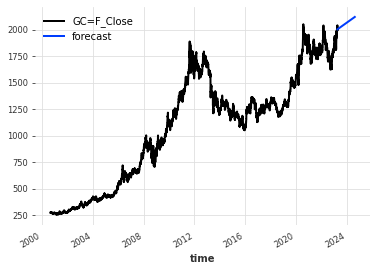

In [177]:
import matplotlib.pyplot as plt

ts.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [65]:
import pickle
with open('forecasted_price', 'wb') as f:
    pickle.dump(forecasted_price, f)

In [ ]:
'''import pickle
with open('Final_v6', 'rb') as f:
    model = pickle.dump(f) '''